In [1]:
def qft_dagger(qc, n):
    for qubit in range(n//2): 
        qc.swap(qubit+1, n-qubit)
    for j in range(n):
        for m in range(j):
            qc.cp(np.pi/float(2**(j-m)), m+1, j+1)
        qc.h(j+1)

In [2]:
def qft(qc, n):
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), clock[m], clock[j])
        qc.h(clock[n-j-1])
    for qubit in range(n//2):
        qc.swap(clock[qubit], clock[n-qubit-1])

In [3]:
def simulate(qpe):
    aer_sim = Aer.get_backend('aer_simulator')
    shots = 2048
    t_qpe = transpile(qpe, aer_sim)
    # qobj = assemble(t_qpe, shots=shots)
    results = aer_sim.run(t_qpe, shots=shots).result()
    answer = results.get_counts()
    for k, v in answer.items():
      answer[k] = answer[k] / shots
    return answer

In [11]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.circuit.library import UnitaryGate, CRYGate
from qiskit import Aer, transpile, assemble, execute
from qiskit.visualization import plot_distribution
import numpy as np
import scipy.linalg as la
import qiskit.quantum_info as qi


state = np.array([0, 1])
H = np.array([[1, -1/3], [-1/3, 1]])

U = np.array([[-1+1j, 1+1j], [1+1j, -1+1j]]) / 2
U = la.expm(1j*H)
# U = la.expm(1j*H*3*np.pi/4)

U_gate = UnitaryGate(U, 'U').control(1)

ancilla = QuantumRegister(1, 'ancilla')
clock = QuantumRegister(2, 'clock')
b = QuantumRegister(1, 'b')
classical = ClassicalRegister(2, 'classical')
circuit = QuantumCircuit(ancilla, clock, b, classical)

for q_idx in range(len(clock)):
    circuit.h(clock[q_idx])   
op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=10)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()

# circuit.prepare_state(state, b)

# circuit = QuantumCircuit(ancilla, clock, b, classical)

for q_idx in range(len(clock)):
    for _ in range(2**q_idx):
        circuit.append(U_gate, [q_idx+1, b])
circuit.barrier()

# op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=4)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()


# circuit = QuantumCircuit(ancilla, clock, b, classical)

qft(circuit, 2)

# op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=4)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()

# circuit = QuantumCircuit(ancilla, clock, b, classical)

circuit.cry(np.pi, clock[0], ancilla)

# op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=10)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()

# circuit = QuantumCircuit(ancilla, clock, b, classical)

circuit.cry(np.pi/3, clock[1], ancilla)

# op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=4)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()
# 
# circuit.measure(ancilla, classical[0])
# 


# circuit = QuantumCircuit(ancilla, clock, b, classical)

qft_dagger(circuit, 2)

# op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=4)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()
# circuit.barrier()
 
# circuit = QuantumCircuit(ancilla, clock, b, classical)

U = np.linalg.inv(U)
U_gate = UnitaryGate(U, 'U-1').control(1)

for q_idx in range(len(clock)):
    for _ in range(2**(len(clock) - q_idx - 1)):
        circuit.append(U_gate, [len(clock) - q_idx, b])
# op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=4)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()

# circuit.barrier()
# 
# circuit = QuantumCircuit(ancilla, clock, b, classical)

for q_idx in range(len(clock)):
    circuit.h(clock[q_idx])
circuit.barrier()

# op = qi.Operator(circuit)
# matrix = np.matrix(op.to_matrix()).round(decimals=5)
# np.savetxt('outfile.txt', matrix.view(float))
# circuit.draw()

circuit.measure(ancilla, classical[0])
circuit.measure(b, classical[1])
measurements = simulate(circuit)
# 
# plot_distribution(measurements)

In [12]:
circuit.draw()

░                        ┌───────┐┌─────────┐»
    ancilla: ─────────────────────░────────────────────────┤ Ry(π) ├┤ Ry(π/3) ├»
             ┌───┐                ░                ┌───┐   └───┬───┘└────┬────┘»
    clock_0: ┤ H ├──■─────────────░───────■────────┤ H ├─X─────■─────────┼─────»
             ├───┤  │             ░ ┌───┐ │P(-π/2) └───┘ │               │     »
    clock_1: ┤ H ├──┼────■────■───░─┤ H ├─■──────────────X───────────────■─────»
             └───┘┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘                                      »
          b: ─────┤ U ├┤ U ├┤ U ├─░────────────────────────────────────────────»
                  └───┘└───┘└───┘ ░                                            »
classical: 2/══════════════════════════════════════════════════════════════════»
                                                                               »
«                                                              ░ ┌─┐   
«    ancilla: ─────────────────────────────────────────────────░─┤M├───
«                ┌───┐                                   ┌───┐ ░ └╥┘   
«    clock_0: ─X─┤ H ├─■─────────────────────────────■───┤ H ├─░──╫────
«              │ └───┘ │P(π/2) ┌───┐                 │   ├───┤ ░  ║    
«    clock_1: ─X───────■───────┤ H ├───■──────■──────┼───┤ H ├─░──╫────
«                              └───┘┌──┴──┐┌──┴──┐┌──┴──┐└───┘ ░  ║ ┌─┐
«          b: ──────────────────────┤ U-1 ├┤ U-1 ├┤ U-1 ├──────░──╫─┤M├
«                                   └─────┘└─────┘└─────┘      ░  ║ └╥┘
«classical: 2/════════════════════════════════════════════════════╩══╩═
«                                                                 0  1

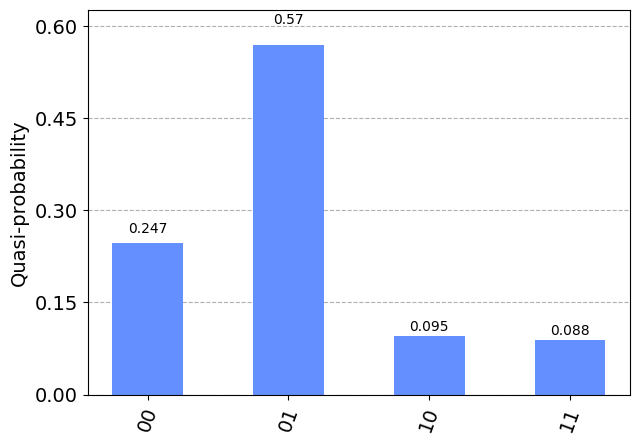

In [13]:
plot_distribution(measurements)

In [55]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.circuit.library import UnitaryGate, CRYGate
from qiskit import Aer, transpile, assemble, execute
from qiskit.visualization import plot_distribution
import numpy as np
import scipy.linalg as la
import qiskit.quantum_info as qi


state = np.array([0, 1])
H = np.array([[1, -1/3], [-1/3, 1]])

U = np.array([[-1+1j, 1+1j], [1+1j, -1+1j]]) / 2
U = la.expm(1j*H)
# U = la.expm(1j*H*3*np.pi/4)

U_gate = UnitaryGate(U, 'U').control(1)

ancilla = QuantumRegister(1, 'ancilla')
clock = QuantumRegister(2, 'clock')
b = QuantumRegister(1, 'b')
classical = ClassicalRegister(2, 'classical')
circuit = QuantumCircuit(ancilla, clock, b, classical)

for q_idx in range(len(clock)):
    circuit.h(clock[q_idx])   
op = qi.Operator(circuit)

for q_idx in range(len(clock)):
    for _ in range(2**q_idx):
        circuit.append(U_gate, [q_idx+1, b])
circuit.barrier()

qft(circuit, 2)

circuit.measure(clock, classical)
measurements = simulate(circuit)

In [56]:
circuit.draw()

░                              
    ancilla: ─────────────────────░──────────────────────────────
             ┌───┐                ░                ┌───┐   ┌─┐   
    clock_0: ┤ H ├──■─────────────░───────■────────┤ H ├─X─┤M├───
             ├───┤  │             ░ ┌───┐ │P(-π/2) └───┘ │ └╥┘┌─┐
    clock_1: ┤ H ├──┼────■────■───░─┤ H ├─■──────────────X──╫─┤M├
             └───┘┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘                   ║ └╥┘
          b: ─────┤ U ├┤ U ├┤ U ├─░─────────────────────────╫──╫─
                  └───┘└───┘└───┘ ░                         ║  ║ 
classical: 2/═══════════════════════════════════════════════╩══╩═
                                                            0  1

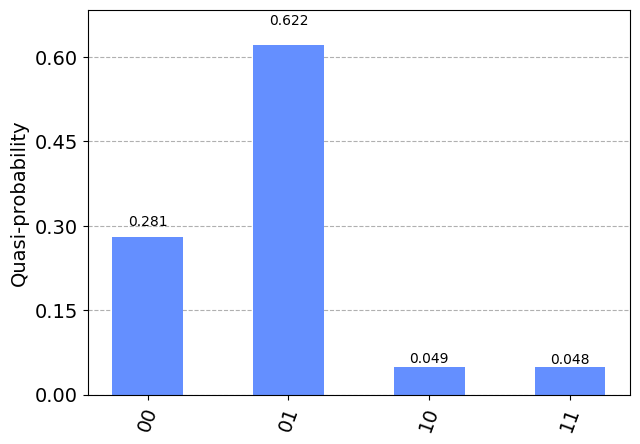

In [57]:
plot_distribution(measurements)

In [58]:
print(f'eigenvalues of unitary matrix {[eig.round(3) for eig in np.linalg.eig(U)[0]]}')
print(f'eigenvalues of Hermitian matrix {[eig.round(3) for eig in np.linalg.eig(H)[0]]}')
# print(np.arctan(0.7858872607769478/0.6183698030697371))
print(f'phases of eigs of Unitary matrix {np.arctan(0.6183698030697371/0.7858872607769478)} and {np.arctan(0.9719379/0.23523757)}')

eigenvalues of unitary matrix [(0.786+0.618j), (0.235+0.972j)]
eigenvalues of Hermitian matrix [1.333, 0.667]
phases of eigs of Unitary matrix 0.6666666666666669 and 1.3333333362229314


In [47]:
print(np.round(la.expm(1j*2*np.pi*1/(2**2)), 3))
print(np.round(la.expm(1j*2*np.pi*2/(2**2)), 3))

[[0.+1.j]]
[[-1.+0.j]]


In [65]:
print(U)

[[-0.5-0.5j  0.5-0.5j]
 [ 0.5-0.5j -0.5-0.5j]]


C:\Users\lisis\AppData\Local\Temp\ipykernel_18824\4098732377.py:70: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(measurements)


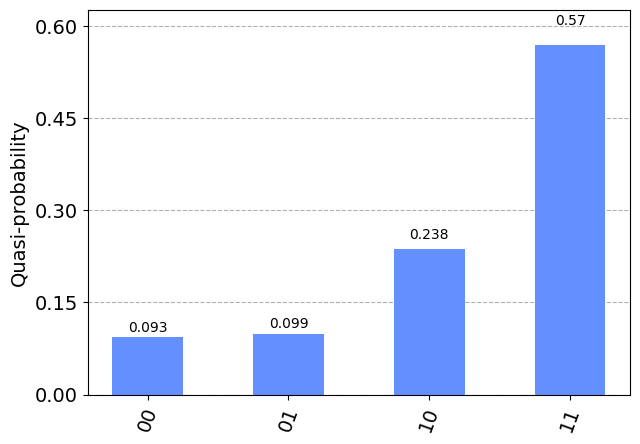

In [76]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.circuit.library import UnitaryGate, CRYGate
from qiskit import Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
from qiskit_aer import QasmSimulator 
import numpy as np
import scipy.linalg as la

import collections

state = np.array([0, 1])
# state = la.expm(-1j*state)
H = np.array([[1, -1/3], [-1/3, 1]])
# U = la.expm(-1j*H)
# print(U)
U = np.array([[-1+1j, 1+1j], [1+1j, -1+1j]]) / 2
U = la.expm(1j*H)
# U = la.expm(1j*H*12*np.pi/4)
# print(U)

U_gate = UnitaryGate(U, 'U').control(1)

ancilla = QuantumRegister(1, 'ancilla')
clock = QuantumRegister(2, 'clock')
b = QuantumRegister(1, 'b')
classical = ClassicalRegister(2, 'classical')
circuit = QuantumCircuit(ancilla, clock, b, classical)
for q_idx in range(len(clock)):
    circuit.h(clock[q_idx])

circuit.prepare_state(state, b)


for q_idx in range(len(clock)):
    for _ in range(2**q_idx):
        circuit.append(U_gate, [q_idx + 1, b])
circuit.barrier()

qft(circuit, 2)

circuit.cry(np.pi, clock[0], ancilla)
circuit.cry(np.pi/3, clock[1], ancilla)

circuit.measure(ancilla, classical[0])

qft_dagger(circuit, 2)
circuit.barrier()

U = np.linalg.inv(U)
U_gate = UnitaryGate(U, 'U-1').control(1)
for q_idx in range(len(clock)):
    for _ in range(2**(len(clock) - q_idx - 1)):
        circuit.append(U_gate, [len(clock) - q_idx, b])
circuit.barrier()

for q_idx in range(len(clock)):
    circuit.h(clock[q_idx])
circuit.barrier()

# simulator = Aer.get_backend("aer_simulator")
# transpiled = transpile(circuit, simulator)
# transpiled.save_statevector()
# result = simulator.run(transpiled).result()
# print(result.get_statevector())

circuit.measure(b, classical[1])
measurements = simulate(circuit)
# print(collections.OrderedDict(sorted(measurements.items())))

plot_histogram(measurements)

In [77]:
circuit.draw()

░                     »
    ancilla: ──────────────────────────────────────────░─────────────────────»
                       ┌───┐                           ░                ┌───┐»
    clock_0: ──────────┤ H ├─────────────■─────────────░───────■────────┤ H ├»
                       ├───┤             │             ░ ┌───┐ │P(-π/2) └───┘»
    clock_1: ──────────┤ H ├─────────────┼────■────■───░─┤ H ├─■─────────────»
             ┌─────────┴───┴──────────┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘               »
          b: ┤ State Preparation(0,1) ├┤ U ├┤ U ├┤ U ├─░─────────────────────»
             └────────────────────────┘└───┘└───┘└───┘ ░                     »
classical: 2/════════════════════════════════════════════════════════════════»
                                                                             »
«                ┌───────┐┌─────────┐┌─┐                       ░               »
«    ancilla: ───┤ Ry(π) ├┤ Ry(π/3) ├┤M├───────────────────────░───────────────»
«                └───┬───┘└────┬────┘└╥┘   ┌───┐               ░               »
«    clock_0: ─X─────■─────────┼──────╫──X─┤ H ├─■─────────────░───────────────»
«              │               │      ║  │ └───┘ │P(π/2) ┌───┐ ░               »
«    clock_1: ─X───────────────■──────╫──X───────■───────┤ H ├─░────■──────■───»
«                                     ║                  └───┘ ░ ┌──┴──┐┌──┴──┐»
«          b: ────────────────────────╫────────────────────────░─┤ U-1 ├┤ U-1 ├»
«                                     ║                        ░ └─────┘└─────┘»
«classical: 2/════════════════════════╩════════════════════════════════════════»
«                                     0                                        »
«                     ░       ░    
«    ancilla: ────────░───────░────
«                     ░ ┌───┐ ░    
«    clock_0: ───■────░─┤ H ├─░────
«                │    ░ ├───┤ ░    
«    clock_1: ───┼────░─┤ H ├─░────
«             ┌──┴──┐ ░ └───┘ ░ ┌─┐
«          b: ┤ U-1 ├─░───────░─┤M├
«             └─────┘ ░       ░ └╥┘
«classical: 2/═══════════════════╩═
«                                1